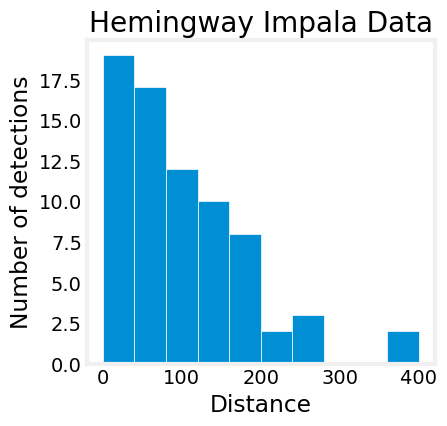

In [1]:
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

x_observed = np.array(
    [71.933980, 26.047227, 58.474341, 92.349221, 163.830409, 84.523652
    ,163.830409, 157.330098, 22.267696, 72.105330, 86.986979, 50.795047
    ,0.000000, 73.135370,  0.000000, 128.557522, 163.830409,  71.845104
    ,30.467336, 71.073909, 150.960702, 68.829172, 90.000000, 64.983827
    ,165.690874, 38.008322, 378.207430, 78.146226, 42.127052, 0.000000
    ,400.000000, 175.386612, 30.467336, 35.069692, 86.036465, 31.686029
    ,200.000000, 271.892336, 26.047227, 76.604444, 41.042417, 200.000000
    ,86.036465, 0.000000, 93.969262, 55.127471, 10.458689, 84.523652
    ,0.000000, 77.645714, 0.000000, 96.418141, 0.000000, 64.278761
    ,187.938524, 0.000000, 160.696902, 150.453756, 63.603607, 193.185165
    ,106.066017, 114.906666, 143.394109, 128.557522, 245.745613, 123.127252
    ,123.127252, 153.208889, 143.394109, 34.202014, 96.418141, 259.807621
    ,8.715574]
)

fig, ax = plt.subplots(figsize=(4,4))

ax.hist(x_observed, edgecolor='white')

ax.set_title('Hemingway Impala Data')
ax.set_ylabel('Number of detections')
ax.set_xlabel('Distance')

ax.grid(False)

plt.show()

In [2]:
M = 500
U_X = 400
U_SIGMA = 400

n = len(x_observed)
unobserved_count = M - n
zeros = np.zeros(unobserved_count)

y = np.ones(n)
y_augmented = np.concatenate((y, zeros))

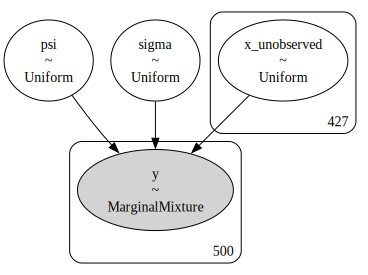

In [3]:
with pm.Model() as distance:
    
    psi = pm.Uniform('psi', 0, 1)
    sigma = pm.Uniform('sigma', 0, U_SIGMA)
    
    x_unobserved = pm.Uniform('x_unobserved', 0, U_X, shape=unobserved_count)
    x_complete = pt.concatenate((x_observed, x_unobserved))

    p = pm.math.exp(- x_complete ** 2 / sigma ** 2)

    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=1, observed=y_augmented)

pm.model_to_graphviz(distance)

In [4]:
with distance:
    distance_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, sigma, x_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


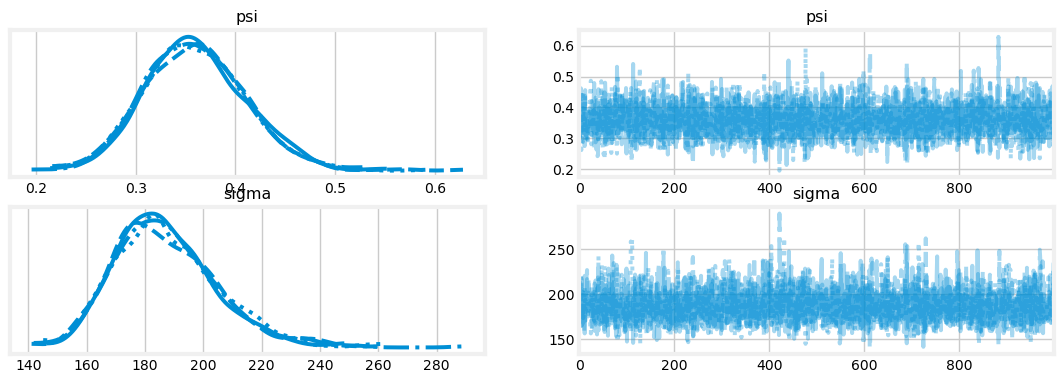

In [5]:
az.plot_trace(distance_idata, var_names=['psi', 'sigma']);

In [6]:
az.summary(distance_idata, var_names=['psi','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.360,0.05,0.267,0.453,0.001,0.001,4161.0,3028.0,1.0
sigma,187.074,17.62,156.457,219.449,0.282,0.203,4227.0,2982.0,1.0


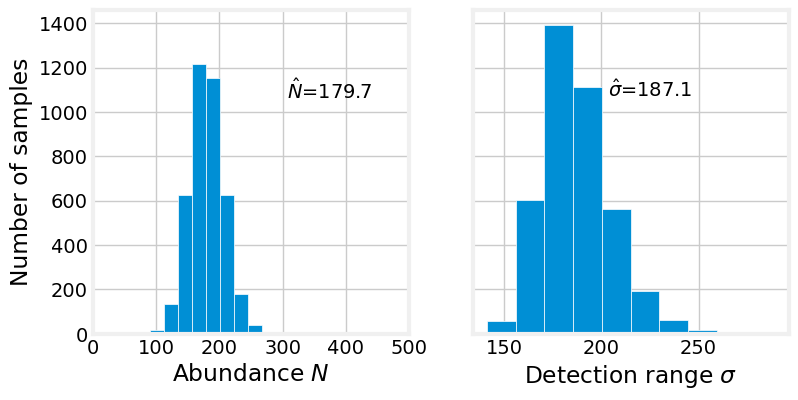

In [7]:
RNG = np.random.default_rng()

# this does not make a copy of the posterior
post = distance_idata.posterior

# simulate draws of N using the posterior of psi 
N_samples = RNG.binomial(M, post.psi)
N_samples = N_samples.flatten()
N_hat = N_samples.mean()

sigma_samples = post.sigma.values.flatten()

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(8,4))

ax0.hist(N_samples, edgecolor='white')

# ax0.set_title('Posterior')
ax0.set_xlabel('Abundance $N$')
ax0.set_ylabel('Number of samples')

# ax0.grid(False)
# ax1.grid(False)

ax0.text(375, 1100, f'$\hat{{N}}$={N_hat:.1f}', ha='center', va='center')

ax0.set_xlim((0,M))

ax1.hist(sigma_samples, edgecolor='white')
ax1.set_xlabel('Detection range $\sigma$')

sigma_hat = sigma_samples.mean()
ax1.text(225, 1100, f'$\hat{{\sigma}}$={sigma_hat:.1f}', ha='center', va='center')
plt.show()

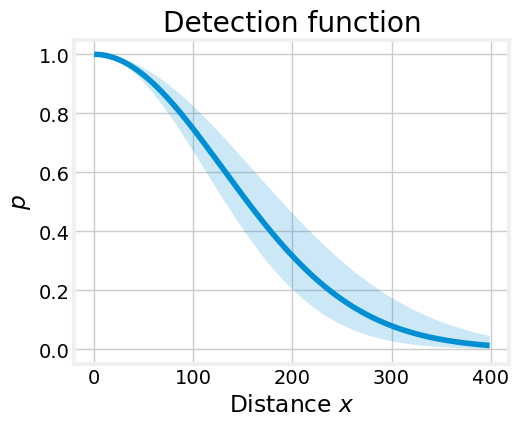

In [8]:
xx = np.arange(400)
sigma_samps = post.sigma.values.flatten()

def det_func(x, s):
    return np.exp(- (x ** 2) / (s ** 2))

p_samps = np.array([det_func(xx, s) for s in sigma_samps])

p_mean = p_samps.mean(axis=0)
p_low = np.quantile(p_samps, 0.025, axis=0)
p_high = np.quantile(p_samps, 0.975, axis=0)

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(xx, p_mean, '-')
ax.fill_between(xx, p_low, p_high, alpha=0.2)

ax.set_title('Detection function')
ax.set_ylabel(r'$p$')
ax.set_xlabel(r'Distance $x$')

plt.show()